In [1]:
import pandas as pd
from sim.model import SeqFeatures, WildcatSimulation, tree_summary
from sim import sum_stats as ss
import time
import tskit
import allel
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import elfi
import scipy.stats

### The simulator

In [2]:
def run_sim(length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
            pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
            captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
            mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
            bottleneck_time_domestic, bottleneck_strength_domestic, random_seed, random_state):
    # TODO: add documentation
    ## NOTE RANDOM SEED SEEDS THE SIMULATION< RANDOM_STATE PROVIDES np.random.RandomState to elfi
    print(pop_size_domestic_1)
    # Constant sequence features
    seq_features = SeqFeatures(length, recombination_rate, mutation_rate)
    sim = WildcatSimulation(seq_features=seq_features, random_seed=random_seed)
    
    # run slim
    slim_param_dict = {
        "pop_size_domestic_1": pop_size_domestic_1,
        "pop_size_wild_1": pop_size_wild_1,
        "pop_size_captive": pop_size_captive,
        "mig_rate_captive": mig_rate_captive,
        "mig_length_wild": mig_length_wild,
        "mig_rate_wild": mig_rate_wild,
        "captive_time": captive_time
    }
    
    command = sim.slim_command(slim_param_dict)
    decap_trees = sim.run_slim(command)
    
    # run msprime
    recapitate_parameters = {
        'pop_size_domestic_2': pop_size_domestic_2,
        'pop_size_wild_2': pop_size_wild_2,
        'bottleneck_time_wild': bottleneck_time_wild,
        'bottleneck_strength_wild': bottleneck_strength_wild,
        'bottleneck_time_domestic': bottleneck_time_domestic,
        'bottleneck_strength_domestic': bottleneck_strength_domestic,
        'mig_rate_post_split': mig_rate_post_split,
        'mig_length_post_split': mig_length_post_split,
        'div_time': div_time,
    }
    
    demographic_events = sim.demographic_model(**recapitate_parameters)
    tree_seq = sim.recapitate(decap_trees, demographic_events)

    # Take samples to match number of samples to the WGS data
    samples = sim.sample_nodes(tree_seq, [5, 30, 10])  
    tree_seq = tree_seq.simplify(samples=np.concatenate(samples))
    return tree_seq

In [3]:
def run_sim_vec(length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
                pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
                captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
                mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
                bottleneck_time_domestic, bottleneck_strength_domestic, random_state,
                batch_size):
    results = []
    
    # Constant sequence features
    seq_features = SeqFeatures(length, recombination_rate, mutation_rate)
    sim = WildcatSimulation(seq_features=seq_features, random_seed=random_state.get_state()[1][0])
    
    # Run simulation with different param values
    for i in range(0, batch_size):
        
        # run slim
        slim_param_dict = {
            "pop_size_domestic_1": int(pop_size_domestic_1[i]),
            "pop_size_wild_1": int(pop_size_wild_1[i]),
            "pop_size_captive": int(pop_size_captive[i]),
            "mig_rate_captive": mig_rate_captive[i],
            "mig_length_wild": int(mig_length_wild[i]),
            "mig_rate_wild": mig_rate_wild[i],
            "captive_time": int(captive_time[i])
        }

        command = sim.slim_command(slim_param_dict)
        decap_trees = sim.run_slim(command)

        # run msprime
        recapitate_parameters = {
            'pop_size_domestic_2': int(pop_size_domestic_2[i]),
            'pop_size_wild_2': int(pop_size_wild_2[i]),
            'bottleneck_time_wild': int(bottleneck_time_wild[i]),
            'bottleneck_strength_wild': int(bottleneck_strength_wild[i]),
            'bottleneck_time_domestic': int(bottleneck_time_domestic[i]),
            'bottleneck_strength_domestic': int(bottleneck_strength_domestic[i]),
            'mig_rate_post_split': mig_rate_post_split[i],
            'mig_length_post_split': int(mig_length_post_split[i]),
            'div_time': int(div_time[i]),
        }

        demographic_events = sim.demographic_model(**recapitate_parameters)
        tree_seq = sim.recapitate(decap_trees, demographic_events)

        # Take samples to match number of samples to the WGS data
        samples = sim.sample_nodes(tree_seq, [5, 30, 10])  
        tree_seq = tree_seq.simplify(samples=np.concatenate(samples))
        results.append(tree_seq)
    
    return np.array(results)

### Create pseudo-observed data

In [4]:
y_obs = run_sim_vec(length=int(5e6),
            recombination_rate=1.8e-8,
            mutation_rate=6e-8,
            pop_size_domestic_1=np.array([50]),
            pop_size_wild_1=[50],
            pop_size_captive=[50],
            captive_time=[20],
            mig_rate_captive=[0.01],
            mig_length_wild=[20],
            mig_rate_wild=[0.01],
            pop_size_domestic_2=[200],
            pop_size_wild_2=[200],
            div_time=[30000],
            mig_rate_post_split=[0.1],
            mig_length_post_split=[5000],
            bottleneck_time_wild=[3000],
            bottleneck_strength_wild=[10000],
            bottleneck_time_domestic=[3000],
            bottleneck_strength_domestic=[10000],
            random_state=np.random.RandomState(3),
            batch_size=1,
            )

Dom: [50], Wild: [50], Cap: [50]


### Set up prior and constants

In [5]:
length = elfi.Constant(int(5e6))
recombination_rate = elfi.Constant(1.8e-8)
mutation_rate = elfi.Constant(6e-8)
pop_size_domestic_1 = elfi.Prior(scipy.stats.uniform, 100, 10000-100)  # scipy.stats.uniform(100, 15000),
pop_size_wild_1 = elfi.Prior(scipy.stats.lognorm, 0.4, 0, np.exp(8))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive = elfi.Prior(scipy.stats.lognorm, 0.3, 0, np.exp(4.5))
mig_rate_captive = elfi.Prior(scipy.stats.beta, 1.2, 40)
captive_time = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_length_wild = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_rate_wild = elfi.Prior(scipy.stats.beta(2, 50))              
pop_size_domestic_2 = elfi.Prior(scipy.stats.uniform, 1000, 20000-1000)  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2 = elfi.Prior(scipy.stats.lognorm, 0.2, 0, np.exp(8.8))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_domestic = elfi.Prior(scipy.stats.norm, 3500, 600)
bottleneck_strength_wild = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_wild = elfi.Prior(scipy.stats.norm, 3500, 600)
mig_length_post_split = elfi.Prior(scipy.stats.uniform, 0, 10000-0)
mig_rate_post_split = elfi.Prior(scipy.stats.truncnorm, 0, 1, 0, 0.1)
div_time = elfi.Prior(scipy.stats.norm, 40000, 5000)

### Initiate simulator node

In [6]:
Y = elfi.Simulator(run_sim_vec,
                   length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
                   pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
                   captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
                   mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
                   bottleneck_time_domestic, bottleneck_strength_domestic, name="simulator", observed=y_obs)

### Set up summary functions

In [7]:
def collected_summaries(tree_seqs):
    results = []
    # TODO: add documentation
    # Calculate summary statistics
    def pca_pipeline(genotypes, pos, pop_list):
        genotypes, pos = ss.maf_filter(genotypes, pos)
        genotypes = genotypes.to_n_alt()  # 012 with ind as cols
        genotypes, pos = ss.ld_prune(genotypes, pos)
        pca_stats = ss.pca_stats(genotypes, pop_list)
        return pca_stats
    
    seq_length = int(tree_seqs[0].get_sequence_length())
    
    for tree_seq in tree_seqs:
        genotypes = ss.genotypes(tree_seq)  # scikit-allel format
        pos = ss.positions(tree_seq)
        sampled_nodes = ss.sampled_nodes(tree_seq)
        pop_list = ss.pop_list(tree_seq)

        # Using a list to call function in for loop so we can use try/except (in case any functions fail)
        summary_functions = [
            ss.tskit_stats(tree_seq, sampled_nodes),
            ss.afs_stats(tree_seq, sampled_nodes),
            # ss.r2_stats(tree_seq, sampled_nodes, [0, 1e6, 2e6, 4e6], ["0_1Mb", "1_2Mb", "2_4Mb"]),
            # ss.roh_stats(genotypes, pos, pop_list, seq_length),  # No longer works due to NetworkX 2.0 clash of requirements with elfi
            pca_pipeline(genotypes, pos, pop_list),
        ]

        #stats_dict = {"random_seed": sim.random_seed}  # Random seed acts as ID
        stats_dict = {}
        
        for func in summary_functions:
            stat = func
            stats_dict = {**stats_dict, **stat}

        results.append(list(stats_dict.values()))
    
    return np.array(results)

In [8]:
summaries = elfi.Summary(collected_summaries, Y)

In [9]:
d = elfi.Distance('euclidean', summaries, name="Euclidean distance")

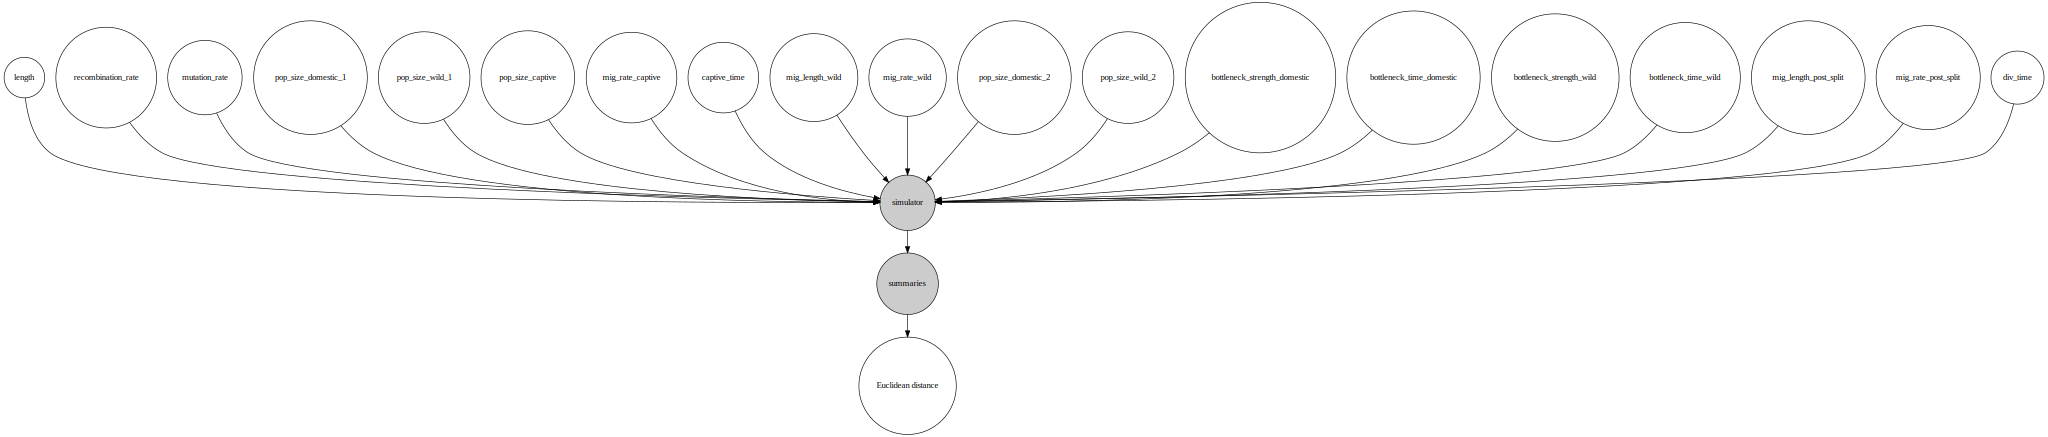

In [10]:
elfi.draw(Y)

In [11]:
%%time
rej = elfi.Rejection(d, batch_size=1, seed=1)

Wall time: 1.99 ms


In [12]:
rej.sample(1)

Dom: [3926.79916728], Wild: [5883.06889181], Cap: [69.83553158]0.0% Complete
Dom: [9877.14929868], Wild: [3423.16923037], Cap: [90.04422021]1.0% Complete
Dom: [4931.51673468], Wild: [5057.41352059], Cap: [82.19315757]2.0% Complete
Dom: [2359.83555292], Wild: [2725.59792256], Cap: [98.80941197]3.0% Complete
Dom: [9110.20353136], Wild: [2183.99636281], Cap: [90.75719732]4.0% Complete
Dom: [9166.61382308], Wild: [7268.30431556], Cap: [98.71830515]5.0% Complete
Dom: [3093.0428398], Wild: [3932.06438201], Cap: [88.53609556] 6.0% Complete
Dom: [9872.46227104], Wild: [2744.28477778], Cap: [136.71049541].0% Complete
Dom: [9980.87470314], Wild: [3414.65844867], Cap: [67.8879257] 8.0% Complete
Dom: [1482.5090062], Wild: [6877.50492298], Cap: [102.16298727]9.0% Complete
Dom: [5676.93354349], Wild: [4055.30944194], Cap: [82.6032196] 10.0% Complete
Dom: [7142.62188836], Wild: [3190.20637709], Cap: [110.62634011]1.0% Complete
Dom: [5261.06776998], Wild: [2375.28761966], Cap: [77.15276908]12.0% Compl

Method: Rejection
Number of samples: 1
Number of simulations: 100
Threshold: 4.27e+03
Sample means: bottleneck_strength_domestic: 3.88e+03, bottleneck_strength_wild: 1.45e+04, bottleneck_time_domestic: 2.73e+03, bottleneck_time_wild: 3.07e+03, captive_time: 52, div_time: 4.19e+04, mig_length_post_split: 4.56e+03, mig_length_wild: 23.9, mig_rate_captive: 0.00865, mig_rate_post_split: 0.00284, mig_rate_wild: 0.0732, pop_size_captive: 108, pop_size_domestic_1: 1.45e+03, pop_size_domestic_2: 2.05e+03, pop_size_wild_1: 1.93e+03, pop_size_wild_2: 5.16e+03